# MNIST-GAN with One-Hot Generator

this is a demo of a GAN network modified prior distribution. instead of going from random noise to a random handwritted digit, this network is trained to take in a one-hot vector and generate a *corresponding* handwritten digit.

main sources:

- Generative Adversarial Text to Image Synthesis (paper)
- https://arxiv.org/pdf/1605.05396.pdf
- GAN by Example using Keras on Tensorflow Backend (blog article)
- https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
- Keras-MNIST-GAN by Zackory (github)
- https://github.com/Zackory/Keras-MNIST-GAN

## imports
 
 we will use the `tensorflow` MNIST data as it comes pre-normalized to `{0-1.0}`. 
 
 also, we will take advantage of the keras `multi_gpu_model` to use dual-GPU training. 

In [15]:
%matplotlib inline 

import numpy as np
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, concatenate
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.optimizers import Adam
from keras import initializers
from keras.utils import multi_gpu_model
from keras.utils import to_categorical

from tensorflow.examples.tutorials.mnist import input_data

In [16]:
# we must do this to tell keras how to handle image data
from keras import backend as K
K.set_image_dim_ordering('th')

## load the MNIST dataset

the images will come as 28x28 scale images flattened to 784 with one channel (black & white)

In [17]:
mnist = input_data.read_data_sets("mnist", one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [18]:
# check shape - flattened 28x28 image
28*28, np.shape(mnist.train.images[1])

(784, (784,))

In [39]:
# get the image data
image_train = mnist.train.images
image_train = image_train.reshape(-1, 1, 28, 28)
np.shape(image_train)

(55000, 1, 28, 28)

In [20]:
# view one image
# image_train[0]

In [21]:
# get the label data (one-hot vectors as set above)
label_train = mnist.train.labels
label_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [22]:
# function to display image
# https://stackoverflow.com/questions/42353676/display-mnist-image-using-matplotlib
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest', cmap='gray')
    return plt

## look at some sample target outputs

we print out some test images for comparison with the generator. we want our generator output to look like this. notice the sharp edges.

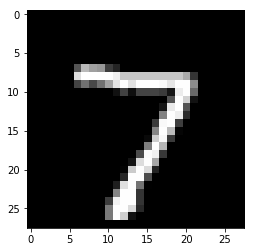

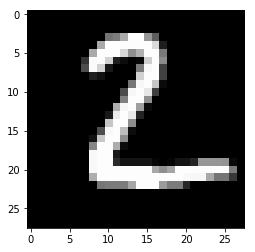

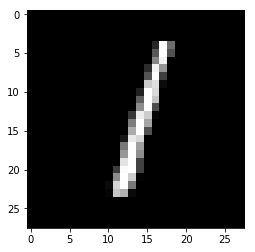

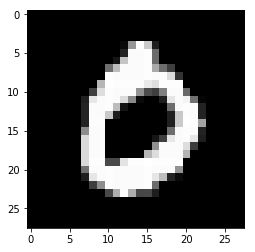

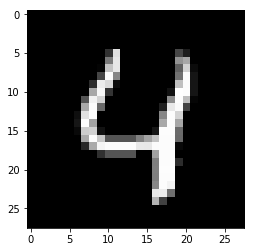

In [23]:
# confirm that the images match the labels (printed in the tuple)
for i in range(5):
    gen_image(mnist.test.images[i]).show()

## network parameters

In [24]:
# the size of the input - this is 10, one for each digit
randomDim = 10

In [25]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

## Generator Network

the generator is a dense network that takes in a vector (one-hot or one-hot with added noise) and learns to "draw" a handwrtitten digit by a series of `Dense` layers that output to a vector of size 784 = 28x28. we will create the network here, pretrain it, and observe the output. We have changed the network slightly from `Zackory`'s  implementation by using a final `sigmoid` activation. This seems reasonable as the `tensorflow` data is normalized between 0 and 1.0.

notice that we are configured for two GPUs so the total batch size will be split equally between them. we make a template model (hence the "t") on the CPU and then assign to each GPU.

In [27]:
with tf.device("/cpu:0"):
    generatort = Sequential()
    generatort.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02),
                        name='gen_dns_1'))
    generatort.add(LeakyReLU(0.2))
    generatort.add(Reshape((128, 7, 7)))
    generatort.add(UpSampling2D(size=(2, 2)))
    generatort.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generatort.add(LeakyReLU(0.2))
    generatort.add(UpSampling2D(size=(2, 2)))
    generatort.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
    generatort.compile(loss='binary_crossentropy', optimizer=adam)

generator = multi_gpu_model(generatort, gpus=2)

generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [28]:
# save the initialized weights to compare later
init_gen_weights = generator.get_weights()

### (pre)-train the model for a few epochs

we will train the network for a few epochs to see how it looks when trained in a traditional supervised method. this pre-training the model also helps the GAN train better.

In [29]:
generatort.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_dns_1 (Dense)            (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [41]:
# supervised training
generator.fit(label_train, image_train, epochs=1, verbose=0, batch_size=32, callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=55000), HTML(value='')))

In [43]:
pretr_gen_weights = generator.get_weights()

### decode some examples to view them

we will use the same first five test examples for comparison

In [44]:
prd_in = mnist.test.labels[0:5]
prd_out = generator.predict(prd_in)

## initial pretraining results

we can see that the network did indeed learn quite a bit about the shape of the characters when trained with this supervised method. however the images don't resemble the targets above subjectively...

7


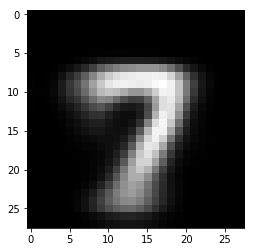

2


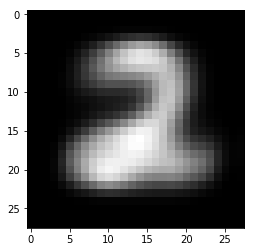

1


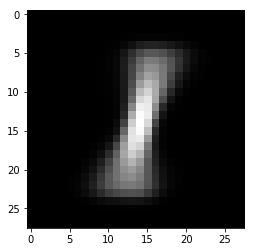

0


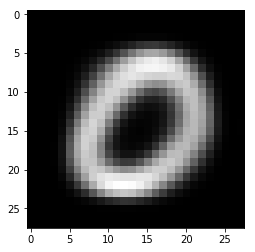

4


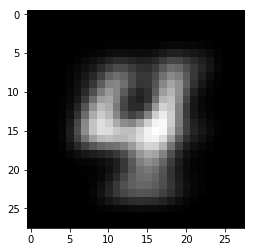

In [45]:
outs = []
for i in range(len(prd_out)):
    print(np.argmax(prd_in[i]))
    gen_image(prd_out[i]).show()

##  Discriminator Network

the discriminator learns to differentiate between the generator outputs and the true images. for example, from the examples above, ideally the discriminator would learn that those blurry edges are poor features (not exactly, but its a good visual analogy).

because we are also trying to create a generator that goes from the desired number to a good image, we should also give the discriminator the original one-hot input along with the image. we should also train it with some negative matches from the true data (and the generated data?) to help it learn this task as well.

due to the multi-input nature, we will use the keras functional API to make this model. The image will go through a series of feed-forward layers, it will be concatenated with the input, and then this vector will output as 0 (Fake/Bad) or 1 (Good)

In [49]:
with tf.device("/cpu:0"):
    # image "reader" as series of dense layers
    img_in = Input(shape=(1, 28, 28, ), name='img_in')
    img = Reshape((784, ))(img_in)
    img = Dense(784, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.02),
                name='img_dns_1')(img)
    img = Dropout(0.2, name='img_drp_1')(img)
    img = Dense(512, activation='relu', name='img_dns_2')(img)
    img = Dropout(0.2, name='img_drp_2')(img)
    img = Dense(384, activation='relu', name='img_dns_3')(img)
    img = Dropout(0.2, name='img_drp_3')(img)
    img = Dense(128, activation='relu', name='img_dns_4')(img)
    
    # one-hot is just added by concatenation
    txt_in = Input(shape=(randomDim, ), name='txt_in')
    cmb = concatenate([img, txt_in])
    
    # final dense layers
    cmb = Dense(64, activation='relu', name='out_dns_1')(cmb)
    out = Dense(1, activation='sigmoid', name='out_dns_2')(cmb)
    
    discriminatort = Model(inputs=[img_in, txt_in], outputs=[out])
    
discriminator = multi_gpu_model(discriminatort, gpus=2)

discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [50]:
discriminatort.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 784)          0           img_in[0][0]                     
__________________________________________________________________________________________________
img_dns_1 (Dense)               (None, 784)          615440      reshape_5[0][0]                  
__________________________________________________________________________________________________
img_drp_1 (Dropout)             (None, 784)          0           img_dns_1[0][0]                  
__________________________________________________________________________________________________
img_dns_2 

In [51]:
init_disc_weights = discriminator.get_weights()

### discriminator training data

this needs at least three sources:

- generator input, true label: FALSE
- true image, true label: TRUE
- true image, false label: FALSE

[Maybe?] these should also be adjusted so the TRUE/FALSE labels are 50/50

In [52]:
# generator output : predicting on the labels
image_train_gen = generator.predict(label_train)
label_train_gen = label_train[:]
value_train_gen = np.zeros(image_train_gen.shape[0]) # FALSE

In [53]:
# true labels are just that
image_train_tru = image_train[:]
label_train_tru = label_train[:]
value_train_tru = np.ones(image_train_tru.shape[0]) # TRUE

In [54]:
# both bad labels need to be constructed
# shift vectors with np.roll
def rollshuffle(vectors):
    rndroll = np.random.randint(1, len(vectors))
    vectors = np.roll(vectors, rndroll, axis=1) 
    return vectors

In [55]:
# test function
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(len(data), data)
data = to_categorical(data, num_classes=randomDim)
data = rollshuffle(data)
data = np.argmax(data, axis=1)
print(len(data), data)

10 [0 1 2 3 4 5 6 7 8 9]
10 [5 6 7 8 9 0 1 2 3 4]


In [56]:
# true images with bad labels
image_train_tru_bad = image_train[:]
label_train_tru_bad = rollshuffle(label_train)
value_train_tru_bad = np.zeros(image_train_tru_bad.shape[0]) # FALSE

In [57]:
# test
label_train[0], label_train_tru_bad[0]

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [58]:
# generator with bad labels
image_train_gen_bad = image_train_gen[:]
label_train_gen_bad = rollshuffle(label_train)
value_train_gen_bad = np.zeros(image_train_gen_bad.shape[0]) # FALSE

In [59]:
# test
label_train[0], label_train_gen_bad[0]

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))

In [60]:
# combine all the images, labels and values (good, bad)
image_train_all = np.concatenate((image_train_gen,
                                  image_train_tru, 
                                  image_train_tru_bad,
                                  # image_train_gen_bad
                                 ), axis=0)
label_train_all = np.concatenate((label_train_gen,
                                  label_train_tru, 
                                  label_train_tru_bad,
                                  # label_train_gen_bad
                                 ), axis=0)
value_train_all = np.concatenate((value_train_gen,
                                  value_train_tru, 
                                  value_train_tru_bad,
                                  # value_train_gen_bad
                                 ), axis=0)

In [61]:
# shuffle
def shufflelist(x, y, z):
    assert(x.shape[0] == y.shape[0])
    assert(y.shape[0] == z.shape[0])
    idx = np.random.permutation(x.shape[0])
    x = x[idx]
    y = y[idx]
    z = z[idx]
    return x, y, z

In [62]:
image_train_all, label_train_all, value_train_all = shufflelist(image_train_all, 
                                                                label_train_all,
                                                                value_train_all)

In [63]:
# pre-training
discriminator.fit([image_train_all, label_train_all], [value_train_all], 
                  epochs=1, verbose=0,
                  callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=165000), HTML(value='')))

In [64]:
pretr_disc_weights = discriminator.get_weights()

### test discriminator

decode on some `test` data

In [68]:
tst_labels = mnist.test.labels[0:3]
bad_labels = rollshuffle(tst_labels)
tst_images = mnist.test.images[0:3].reshape(-1, 1, 28, 28)
gen_images = generator.predict(tst_labels)

In [70]:
# test various combinations if you want, but importantly these should be FALSE
# this shows that the discriminator can identify generated images vs trues
prd_outs = discriminator.predict([gen_images, tst_labels])
outs = []
for i in prd_outs:
    if i > 0.5:
        print(i, 'TRUE')
    else:
        print(i, "FALSE")
        prd_outs = discriminator.predict([tst_images, tst_labels])
outs = []
for i in prd_outs:
    if i > 0.5:
        print(i, 'TRUE')
    else:
        print(i, "FALSE")

[4.7446065e-08] FALSE
[7.975936e-08] FALSE
[1.3813974e-06] FALSE
[0.9940339] TRUE
[0.98552877] TRUE
[0.9912265] TRUE


## data-generation function

add the above discriminator dataset generation code to a function for easy calling in GAN

In [78]:
def getdiscriminatordata(labelBatch, imageBatch, imageGen, batchSize):
    # generator output : predicting on the labels
    image_train_gen = imageGen[:]
    label_train_gen = labelBatch[:]
    value_train_gen = np.zeros(image_train_gen.shape[0]) # FALSE
    # true labels are just that
    image_train_tru = imageBatch[:]
    label_train_tru = labelBatch[:]
    value_train_tru = np.ones(image_train_tru.shape[0]) # TRUE
    # true images with bad labels
    image_train_tru_bad = imageBatch[:]
    label_train_tru_bad = rollshuffle(labelBatch)
    value_train_tru_bad = np.zeros(image_train_tru_bad.shape[0]) # FALSE
    # generator with bad labels
    #image_train_gen_bad = image_train_gen[:]
    #label_train_gen_bad = rollshuffle(labelBatch)
    #value_train_gen_bad = np.zeros(image_train_gen_bad.shape[0]) # FALSE
    # combine all the images, labels and values (good, bad)
    image_train_all = np.concatenate((image_train_gen,
                                      image_train_tru, 
                                      image_train_tru_bad,
                                      #image_train_gen_bad
                                     ), axis=0)
    label_train_all = np.concatenate((label_train_gen,
                                      label_train_tru, 
                                      label_train_tru_bad,
                                      #label_train_gen_bad
                                     ), axis=0)
    value_train_all = np.concatenate((value_train_gen,
                                      value_train_tru, 
                                      value_train_tru_bad,
                                      #value_train_gen_bad
                                     ), axis=0)
    
    image_train_all, label_train_all, value_train_all = shufflelist(image_train_all, 
                                                                label_train_all,
                                                                value_train_all)
    
    return image_train_all, label_train_all, value_train_all

## GAN network

we make some modifications by outputting both the generator network output and the discriminator output, and training the network on both.

In [79]:
# Combined network
discriminator.trainable = False

# the input to the generator
# the generator output is considered as one terminal layer
# and loss calculated by difference from TRUE image
genInput = Input(shape=(randomDim,), name='gen_in')
genOutput = generator(genInput)

# the discriminator takes the generator output
dscInput = Input(shape=(1, 28, 28,), name='dsc_in')
dscOutput = discriminator([genOutput, genInput])

# here we make the final joint model
# we weight the generator output more than the GAN output
gan = Model(inputs=[genInput, dscInput], outputs=[genOutput, dscOutput])
gan.compile(loss='binary_crossentropy', loss_weights=[1.0, 1.0], optimizer=adam)

In [80]:
def gantrain(epochs=15, batchSize=64):
    
    batchCount = int(label_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        # print('-'*15, 'Epoch %d' % e, '-'*15)
        # print out images per x epochs
        # if e % 5 == 0:
        prd_in = mnist.test.labels[0:5]
        prd_out = generator.predict(prd_in)
        i = 1
        gen_image(prd_out[i]).show()
        
        for _ in tqdm(range(batchCount)):
            
            # get a random set of inputs and images
            labelBatch = label_train[np.random.randint(0, label_train.shape[0], size=batchSize)]
            imageBatch = image_train[np.random.randint(0, image_train.shape[0], size=batchSize)]
            
            # generate images from the inputs
            imageGen = generator.predict(labelBatch)
            
            # generate full training data for discriminator
            X1, X2, yDis = getdiscriminatordata(labelBatch, imageBatch, imageGen, batchSize)
            
            # train discriminator with this fuller data
            discriminator.trainable = True
            dloss = discriminator.train_on_batch([X1, X2], yDis)

            # train generator
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            # print(labelBatch.shape, imageBatch.shape, yGen.shape)
            gloss = gan.train_on_batch([labelBatch, imageBatch], [imageBatch, yGen])
            

Epochs: 20
Batch size: 64
Batches per epoch: 859


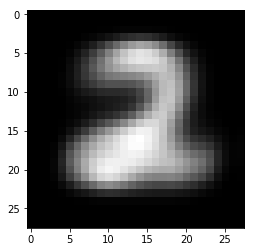

100%|██████████| 859/859 [00:27<00:00, 30.74it/s]


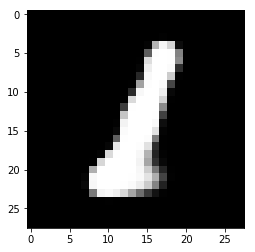

100%|██████████| 859/859 [00:27<00:00, 30.77it/s]


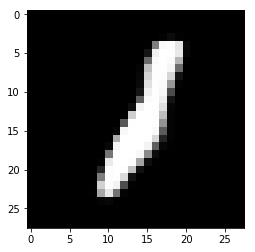

 47%|████▋     | 405/859 [00:13<00:14, 30.81it/s]

KeyboardInterrupt: 

In [82]:
# if retraining over and over, reset weights
generator.set_weights(pretr_gen_weights)
discriminator.set_weights(init_disc_weights)
gantrain(20, 64)

In [ ]:
prd_in = mnist.test.labels[0:5]
tru_out = mnist.test.images[0:5]
prd_out = generator.predict(prd_in)

outs = []
for i in range(len(prd_out)):
    print(np.argmax(prd_in[i]))
    gen_image(prd_out[i]).show()
    gen_image(tru_out[i]).show()

## baseline generator comparison

the generator model was trained for a total of 7 epochs (2 pre-training and 5 in adverserial). so we can reset the weights and train for 20 epochs in normal supervised to compare.

In [ ]:
# reset with the initial saved state
generator.set_weights(init_gen_weights)
# supervised training
generator.fit(label_train, image_train, epochs=7, verbose=0,
             callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

In [ ]:
prd_in = mnist.test.labels[0:5]
tru_out = mnist.test.images[0:5]
prd_out = generator.predict(prd_in)

outs = []
for i in range(len(prd_out)):
    print(np.argmax(prd_in[i]))
    gen_image(prd_out[i]).show()
    gen_image(tru_out[i]).show()